# NLP_07 LAB_2 - BERT Fine Tuning (TensorFlow)
Created by NLP SQUAD Orbit Future Academy<br>
Rabu, 13 April 2022

Setelah mempelejari teori bagaimana melakukan fine-tuning menggunakan BERT, selanjutnya kita belajar bagaimana mengimpelementasikannya pada kasus klasifikasi SMS spam. Skema yang akan kita lakukan akan mengikuti bagan berikut:

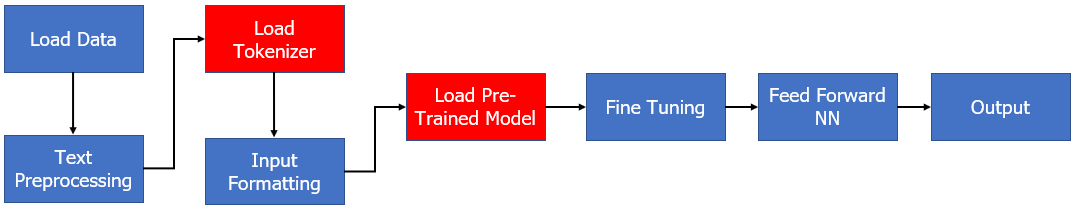

**Catatan**: Tokenizer dan model harus dari pre-trained model yang sama.
<hr>

Kita akan menggunakan pre-trained model bahasa Indonesia yang disediakan oleh B. Wilie et al. yaitu IndoBERT (2020).

*B. Wilie et al., “IndoNLU: Benchmark and Resources for Evaluating Indonesian Natural Language Understanding,” 2020, doi: [10.48550/arXiv.2009.05387](https://arxiv.org/abs/2009.05387)).*

https://huggingface.co/indobenchmark/indobert-base-p2


# 01 Install & Import Library

In [ ]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
%tensorflow_version 2.x

# Gunakan tensorflow versi 2
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Instal libray transformer https://huggingface.co/
!pip -q install transformers

In [ ]:
import transformers
print(transformers.__version__)

# 02 Load Data

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

In [ ]:
data = pd.read_csv('dataset_sms_spam_v1.csv')
data.head()

In [ ]:
# Copy data
raw_data = data.copy()

# 03 Text Preprocessing

In [ ]:
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
%time data['teks'] = data['teks'].apply(text_preprocessing)

In [ ]:
data.head()

# 04 Train & Test Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

df_train.shape, df_test.shape, df_val.shape

# 05 Load Tokenizer

In [ ]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2

In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model

In [ ]:
# Lihat vocabulary dari pre-trained model yang telah di load sebelumnya
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))
print(vocabulary)

In [ ]:
# Contoh Tokenisasi

id_data = 5 # Mengambil data indeks ke-5 pada dataframe

print('Kalimat:', raw_data.teks[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.teks[id_data]))

# 06 Input Formating
Teks harus dipecah menjadi token sebelum dimasukkan ke BERT, kemudian token tersebut harus dipetakan ke indeks pada kosakata tokenizer yang telah di load sebelumnya. Tokenisasi harus dilakukan oleh tokenizer yang disertakan dengan BERT.

## Contoh Input Formatting

In [ ]:
# Contoh input formatting untuk BERT. Input formating dapat menggunakan fungsi `encode_plus`

bert_input = bert_tokenizer.encode_plus(
    data.teks[id_data],             # Sample kalimat                
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 50,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

In [ ]:
print('Kalimat\t\t:', raw_data.teks[id_data])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])                                # Attention mask : mengembalikan nilai [0,1]. 1 artinya token yang di masking, 0 token yang tidak di masking (diabaikan)

## Memilih Panjang Sequence (max_length)

In [ ]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for txt in data.teks:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
# Dapat dilihat dari grafik diatas, sebagian besar kalimat tampaknya berisi kurang dari 80 token
# Maka, tentukan max_length adalah 80

MAX_LEN = 80

## Input Formatting pada Data Latih & Uji

In [ ]:
# Buat fungsi untuk menggabungkan langkah tokenisasi, menambahkan special tokens untuk keseluruhan data sebagai input formatting ke model BERT
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

In [ ]:
# Buat fungsi untuk memetakan input hasil input formatting agar sesuai dengan model BERT
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

In [ ]:
# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# Tentukan nilai hyperparamter untuk fine-tuning
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [ ]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

# 07 Load Pre-Trained Model

In [ ]:
'''
BERT untuk tugas klasifikasi sequence (teks) dengan menambahkan linear layer di atas pooled output untuk pengklasifikasi
https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification
'''

from transformers import TFBertForSequenceClassification

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)

In [ ]:
# Tentukan optimizer dengan learning rate tertentu
# Paper aslinya menggunakan Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 08 Fine Tuning

In [ ]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCHS):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, bert_history.history['accuracy'][i], bert_history.history['loss'][i], bert_history.history['val_accuracy'][i], bert_history.history['val_loss'][i]))

In [ ]:
bert_model.save_weights('bert-model.h5')

# 09 Evaluate

In [ ]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

# 10 Predict

In [ ]:
# Load hasil fine-tuning
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)
bert_load_model.load_weights('bert-model.h5')

In [ ]:
# Sample text
input_text = 'Special promo Ramadhan, Idul Fitri, dan Arus Balik!'

# Encode input text
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')

In [ ]:
bert_predict = bert_load_model(input_text_tokenized)          # Lakukan prediksi
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         # Softmax function untuk mendapatkan hasil klasifikasi

In [ ]:
sms_labels = ['Normal','Fraud','Promo']

label = tf.argmax(bert_output, axis=1)
label = label.numpy()

In [ ]:
print(input_text, ':', sms_labels[label[0]])

# 11 Deployment Using Gradio

In [ ]:
'''
Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
https://gradio.app/
'''

!pip -q install gradio

In [ ]:
import gradio as gr

def spam_prediction(sms):
  input_text_tokenized = bert_tokenizer.encode(sms,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')
  
  bert_predict = bert_load_model(input_text_tokenized)
  bert_output = tf.nn.softmax(bert_predict[0], axis=-1)

  sms_labels = ['Normal','Fraud','Promo']
  
  label = tf.argmax(bert_output, axis=1)
  label = label.numpy()

  return sms_labels[label[0]]

iface = gr.Interface(fn=spam_prediction, inputs="text", outputs="text")
iface.launch()

# Student Activity
Buat resume perbandingan metode tradisional ML, LSTM, dan fine-tuning BERT pada data klasifikasi SMS Spam.
- Gunakan metrics akurasi untuk melihat performa metode diatas;
- Analisa hasil performa setiap metode;
- metode mana yang lebih baik, dari segi komputasi dan performa? Jelaskan mengapa?


Kumpulkan dalam format PDF. Kumpulkan paling lambat tanggal 19 April 2022 23.59 WIB.<br>
Link pengumpulkan tugas: https://s.id/tugas-nlp-ofa

